# DTSA-5511:  Week 4 - Kaggle Mini Project
### September 24, 2022


## Natural Language Processing with Disaster Tweets
### Introduction

This is the Week 4 assignment for DTSA-5511, Introduction to Deep Learning. This project applies a Recurrent Neural Network (RNN) to a text dataset in an attempt to identify the text as being related to a disaster or not. The text dataset comes from a [Kaggle Competition](https://www.kaggle.com/competitions/nlp-getting-started) and consists of a training set and testing set of tweets with each of the tweets in the training set having been labelled as relating to a disaster or not.  For the purposes of the competition, submitted models are evaluated on its F1 score, so that will be the primary evaluation criteria used to evaluate the models fitted in this notebook

When fitting the model, a process called Natural Language Processing (NLP) will be used to determine whether the text refers to disaster or not. NLP combines computational linguistics—rule-based modeling of human language—with statistical, machine learning, and deep learning models. Together, these technologies enable computers to process human language in the form of text or voice data and to ‘understand’ its full meaning, complete with the speaker or writer’s intent and sentiment.$^1$

This Jupyter notebook can be downloaded from https://github.com/clayv/DTSA-5511_Week4.

**References:**  
$^1$IBM. Natural Language Processing (NLP). 
https://www.ibm.com/cloud/learn/natural-language-processing  

_Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow_, 2nd Edition, by Aurélien Géron (O'Reilly).  
Copyright 2019 Kiwisoft S.A.S., 978-1-492-03264-9 


In [25]:
from collections import Counter
import keras
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import Dense, Dropout, Embedding, GRU, LSTM
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import nltk
from nltk.corpus import stopwords
import numpy as np
import os
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, roc_curve, roc_auc_score
import tensorflow as tf

#Change to None if results other than those documented are desired
randomState = 42

In [2]:
#Globals
DIR_DL_BASE = "./data"
DL_TRAIN_DATA = os.path.join(DIR_DL_BASE, "train.csv")
DL_TEST_DATA =  os.path.join(DIR_DL_BASE, "test.csv")
DIR_MODEL_TRAIN = "./Training"

LABELS = ["Disaster", "Not Disaster"]
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

### Exploratory Data Analysis
The provided dataset consists of a training and testing dataset, with the tweets in the training set having labels and the testing set to be used to compute a submission placement on the Kaggle competition's leaderboard.

The training set and testing have 7,613 and 3,263 tweet respectively and both have columns that will not be required for our NLP modeling (keyword and location).

In [3]:
dfTrain = pd.read_csv(DL_TRAIN_DATA)
dfTest = pd.read_csv(DL_TEST_DATA)

print(dfTrain.info())
print(dfTest.info())
dfTrain.head(2)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB
None


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1


The tweets in the training dataset are split fairly evenly across the "Disaster" and "Not Disaster" categories (57.03% and 42.97% respectively) and vary in length from 7 to 157 characters (including spaces) with an average of ~101 characters.  

Minimum Tweet Length: 7 characters
Maximimum Tweet Length: 157 characters
Mean Tweet Length: 101.03743596479706 characters


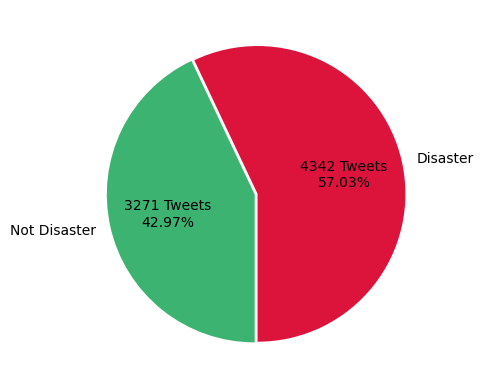

In [4]:
print("Minimum Tweet Length: {0} characters".format(min(dfTrain.text.str.len())))
print("Maximimum Tweet Length: {0} characters".format(max(dfTrain.text.str.len())))
print("Mean Tweet Length: {0} characters".format(np.mean(dfTrain.text.str.len())))

values = [len(dfTrain[dfTrain.target == 0]), len(dfTrain[dfTrain.target == 1])]
plt.pie(values, explode = [.01, .01], labels = LABELS, colors = ['crimson', 'mediumseagreen'], 
        autopct = (lambda value:f'{value * sum(values) / 100 :.0f} Tweets\n{value:.2f}%'), 
        pctdistance = 0.6, shadow = False, labeldistance = 1.1, startangle = -90, 
        radius = 1, counterclock = True, wedgeprops = None, textprops = None, center = (0, 0), 
        frame = False, rotatelabels = False, normalize = True, data = None)
plt.show()

After examining the top 60 words though some data cleanup will be necessary.

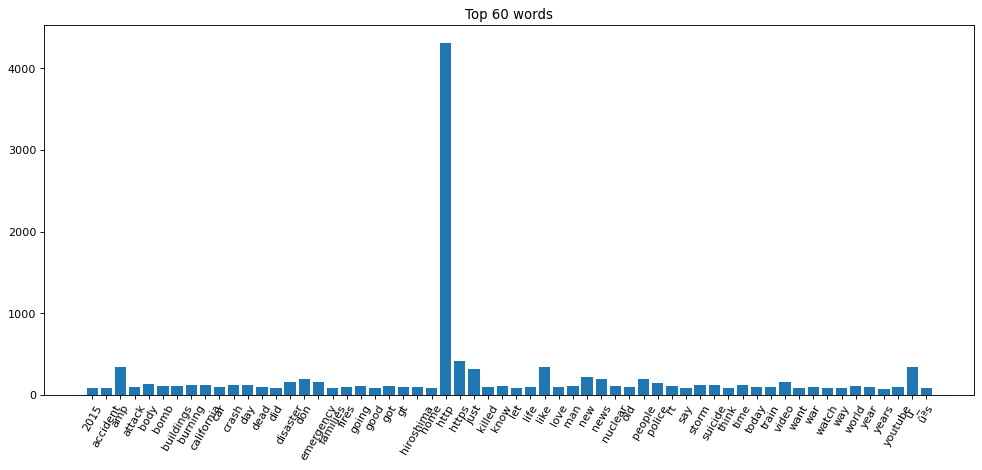

In [5]:
topWordCount = 60
vectorizer = CountVectorizer(max_df = 0.80, min_df = 2, max_features = topWordCount, stop_words = "english")

vectTrain = vectorizer.fit_transform(dfTrain.text)     

figure(figsize=(15, 6), dpi=80)
plt.title("Top {} words".format(topWordCount))
plt.bar(x = vectorizer.get_feature_names_out(), height = np.sum(vectTrain.toarray(), axis=0))
plt.xticks(rotation = 60)
plt.show()


The preprocessing will consist of 3 steps:
1. All text will be changed to lower case 
2. All numbers will be removed
3. All occurences of "http://" and "https://" will be removed 

In [6]:
def preprocessDataFrame(df):
    #Change all words to lower case
    df.text = df.text.transform(lambda tweet: tweet.lower())
    #Remove all numbers
    df.text.replace(to_replace = "\\b[0-9]*\\b", value = "", inplace = True, regex = True)
    #Remove "http://" and "https://"
    for word in ("http://", "https://"):
        df.text.replace(to_replace = "\\b" + word + "\\b", value = "", inplace = True, regex = True)

preprocessDataFrame(dfTrain)


To support the Keras function [text_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/utils/text_dataset_from_directory) the labeled training set will be placed into two different directories based on whether or not a tweet is labeled as pertaining to a disaster or not. This task is split across the next two cells with the first cell creating the directory structure and the second writing and file for each labeled tweet in the appropriate directory.

In [7]:
def makeDirectory(directory):
    try:
        os.mkdir(directory)
    except:
        pass
    
def createTrainDirStructure(directory, createNew):
    try:
        !rmdir /s /q "./Training"
        makeDirectory(directory)
    except:
        pass

    dirDisaster = os.path.join(directory, LABELS[0])
    dirNotDisaster = os.path.join(directory, LABELS[1])
    
    makeDirectory(dirDisaster)
    makeDirectory(dirNotDisaster)
        
    return dirDisaster, dirNotDisaster

dirModelTrainDisaster, dirModelTrainNotDisaster = createTrainDirStructure(DIR_MODEL_TRAIN, True)


In [8]:
for row in dfTrain.itertuples():
    fileName = str(row.id) + ".txt"
    #Change the destination directory based on how the record is labeled
    if row.target == 0:
        dest = os.path.join(dirModelTrainNotDisaster, fileName)
    else:
        dest = os.path.join(dirModelTrainDisaster, fileName)
    with open(dest, 'w', encoding='utf-8') as f:
        f.write(row.text)

### Model Architecture and Design
Before begining model design and experimentation, some additional steps will be required to prepare the textual data for analysis with numerical methods.

First, because only a training and testing set were provided, a validation dataset will be made by taking a random subset of 10% of the training data. 

In [55]:
tfdsTrain, tfdsValid = tf.keras.utils.text_dataset_from_directory(
    DIR_MODEL_TRAIN,
    labels = "inferred",
    label_mode = "int",
    class_names = LABELS,
    batch_size = 32,
    max_length = None,
    shuffle = True,
    seed = randomState,
    validation_split = 0.1,
    subset = 'both',
    follow_links = False,
)

Found 7613 files belonging to 2 classes.
Using 6852 files for training.
Using 761 files for validation.


Next the text of each tweet in the training set will split into individual words. Typically this would result in a "ragged" array (as the tweets vary in length).  To fix that, when converting to a tensor, a special padding word "\<pad\>" will be used to create arrays of equal length for TensorFlow to work with.  

Once split into words, a Python counter object is used to keep track of each words usage.

In [103]:
def preprocessDataSet(x_batch, y_batch = None):
    #Split the words on spaces
    x_batch = tf.strings.split(x_batch)
    #Pad the arrays to the same shape to avoid errors in TensorFlow
    if y_batch == None:
        return x_batch.to_tensor(default_value = b"<pad>")
    else:
        return x_batch.to_tensor(default_value = b"<pad>"), y_batch

vocabulary = Counter()
for x_batch, y_batch in tfdsTrain.map(preprocessDataSet):
    for tweet in x_batch:
        #Update the Python Counter object with the counts of each word
        vocabulary.update(tweet.numpy())


Commonly occuring words in the English language such as "a", "the", "of", etc. should not add any value to predicting whether a tweet refers to a disaster or not. These commonly occurring words are refered to as "stop words". A list of stop words will be downloaded from the [Natural Language Toolkit](https://www.nltk.org) and any word in the tweets which are in the list of English language stop words will have their count set to 0.  

In [57]:
nltk.download('stopwords')
#Create a "set" from the stopword for faster lookups
stopWords = set(stopwords.words('english'))

uncommonWordCount = 0
for word in vocabulary:
    #The strings in _vocabulary_ are actually stored a bytes, so decode
    #them to do the comparison with the words in _stopwords_
    if word.decode('utf-8') in stopWords:
        vocabulary[word] = 0
    else:
        uncommonWordCount += 1
print("Remaining word count: ", uncommonWordCount)

Remaining word count:  25124


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\clayv\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Next the top 50% of the most common words remaining will each be assigned a number and be split into buckets with 10 words each to enable a quick lookup table.

In [58]:
# Python right bit-shift operator ">>" is used to quickly divide the count by 2 by shifting the number right 1 bit
maxVocab = [word for word, count in vocabulary.most_common()[:uncommonWordCount >> 1]]
words = tf.constant(maxVocab)
wordIds = tf.range(len(maxVocab), dtype = tf.int64)
initVocab = tf.lookup.KeyValueTensorInitializer(words, wordIds)
numBuckets = uncommonWordCount // 10
table = tf.lookup.StaticVocabularyTable(initVocab, numBuckets)


Lastly, the actual data the model will be trained on and validated with is created by using the lookup table created in the previous cell to "translate" each word to a number.

In [101]:
def encode_words(x_batch, y_batch = None):
    if (y_batch == None):
        return table.lookup(x_batch)
    else:
        return table.lookup(x_batch), y_batch

train_set = tfdsTrain.map(preprocessDataSet)
train_set = train_set.map(encode_words).prefetch(1)
validation_set = tfdsValid.map(preprocessDataSet)
validation_set = validation_set.map(encode_words).prefetch(1)

### Initial Model
The initial model will use simple 2 layer Gated Recurrent Unit model with the second layer returning only the output (return_sequences = False, the default). This feeds into a Dense layer outputing a single neuron with the probability that the tweet is about a disaster.

In [60]:
modelEmbedSize = 32
model = Sequential()
model.add(Embedding(uncommonWordCount + numBuckets, modelEmbedSize, input_shape = [None]))
model.add(GRU(128, return_sequences = True))
model.add(GRU(128))
model.add(Dense(1, activation = "sigmoid"))

model.compile(optimizer = keras.optimizers.Adam(learning_rate = 0.0001), 
              loss = keras.losses.BinaryCrossentropy(from_logits = False), 
              metrics = METRICS)


Now a set of callbacks will be created for learning rate reductions and early stopping during model fitting followed by the actual fitting of the model.

In [61]:
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.5, patience = 2, 
                              verbose = 1, mode = 'max', min_lr = 0.000001)
earlyStop = EarlyStopping(monitor='loss', patience = 3)
callbacks_list = [reduce_lr, earlyStop]

histModel1 = model.fit(train_set, validation_data = validation_set, epochs = 10, callbacks = callbacks_list, verbose = False)


Epoch 6: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 8: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 10: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.


The **plotTrainingResults** function will display the F1 score for the model as well a plot several charts of interest detailing how the fitting process went.

24/24 [==============================] - 1s 3ms/step
F1 Score:  0.7981859410430838


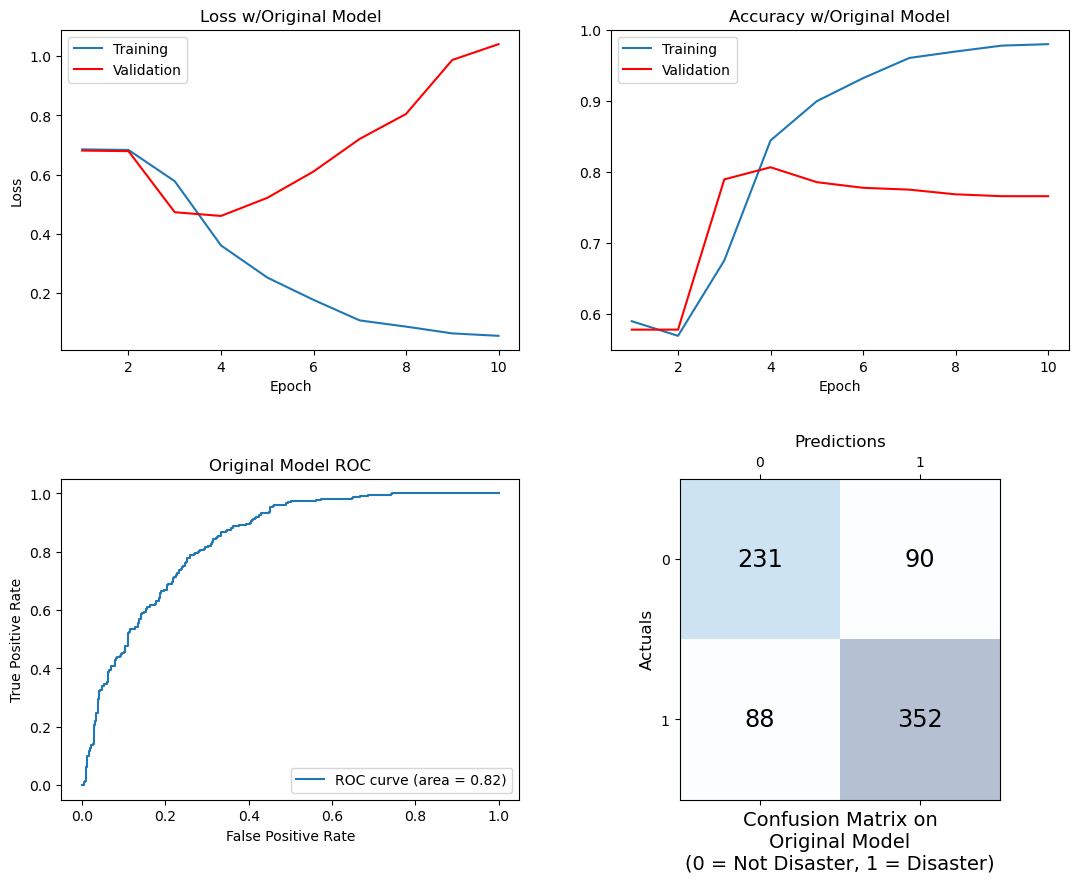

In [62]:
def plotTrainingResults(history, actuals, predictions, dataName):
    binaryPredictions = np.where(predictions < .5, 0, 1)
    print("F1 Score: ", f1_score(actuals, binaryPredictions))
    
    fig, ax = plt.subplots(2, 2, figsize=(13, 10))
    
    upper = len(history['loss']) + 1

    ax[0, 0].plot(np.arange(1, upper), history['loss'], label = 'Training')
    ax[0, 0].plot(np.arange(1, upper), history['val_loss'], label = 'Validation', color = 'red')
    ax[0, 0].set(xticks=np.arange(2, upper, 2))
    ax[0, 0].set_xlabel('Epoch')
    ax[0, 0].set_ylabel('Loss')
    ax[0, 0].set_title("Loss w/" + dataName)
    ax[0, 0].legend()

    ax[0, 1].plot(np.arange(1, upper), history['accuracy'], label = 'Training')
    ax[0, 1].plot(np.arange(1, upper), history['val_accuracy'], label = 'Validation', color = 'red')
    ax[0, 1].set(xticks=np.arange(2, upper, 2))
    ax[0, 1].set_xlabel('Epoch')
    ax[0, 1].set_title("Accuracy w/" + dataName)
    ax[0, 1].legend()

    fpr, tpr, threshold = roc_curve(actuals, predictions)
    ax[1, 0].plot(fpr, tpr, label='ROC curve (area = %0.2f)' % history['val_auc'][-1])
    ax[1, 0].set_xlabel('False Positive Rate')
    ax[1, 0].set_ylabel('True Positive Rate')
    ax[1, 0].set_title(dataName + " ROC")
    ax[1, 0].legend(loc="lower right")
    
    cm = confusion_matrix(actuals, binaryPredictions)

    ax[1, 1].matshow(cm, cmap = plt.cm.Blues, alpha = 0.3)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax[1, 1].text(x = j, y = i, s = cm[i, j], va='center', ha='center', size='xx-large')
    ax[1, 1].set_xlabel("Confusion Matrix on\n" + dataName + "\n(0 = Not Disaster, 1 = Disaster)", fontsize = 14)
    ax[1, 1].set_ylabel('Actuals', fontsize = 12)
    ax[1, 1].set_title('Predictions', fontsize = 12)    

    plt.subplots_adjust(hspace = 0.4)
    plt.show()
    
preds = model.predict(validation_set)
actuals = []
for _, y in validation_set:
    actuals.extend(list(y))
plotTrainingResults(histModel1.history, actuals, preds, "Original Model")

From the charts above, the first item of notice is how quickly the model trains and that the Generalization Gap begins by epoch 4, with the gap continuing to widen through epoch 10.  

### Alternate Models and Hyperparameter Tuning

The speed the model trained at could be due to the model not being "deep" enough, so another model with more layers was tried with gradually increasing units from 16 to 128. Although this did improve the F1 score a **little** bit, it does not seem worth the addtional complexity.


Epoch 6: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 8: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 10: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
24/24 [==============================] - 1s 4ms/step
F1 Score:  0.7990867579908675


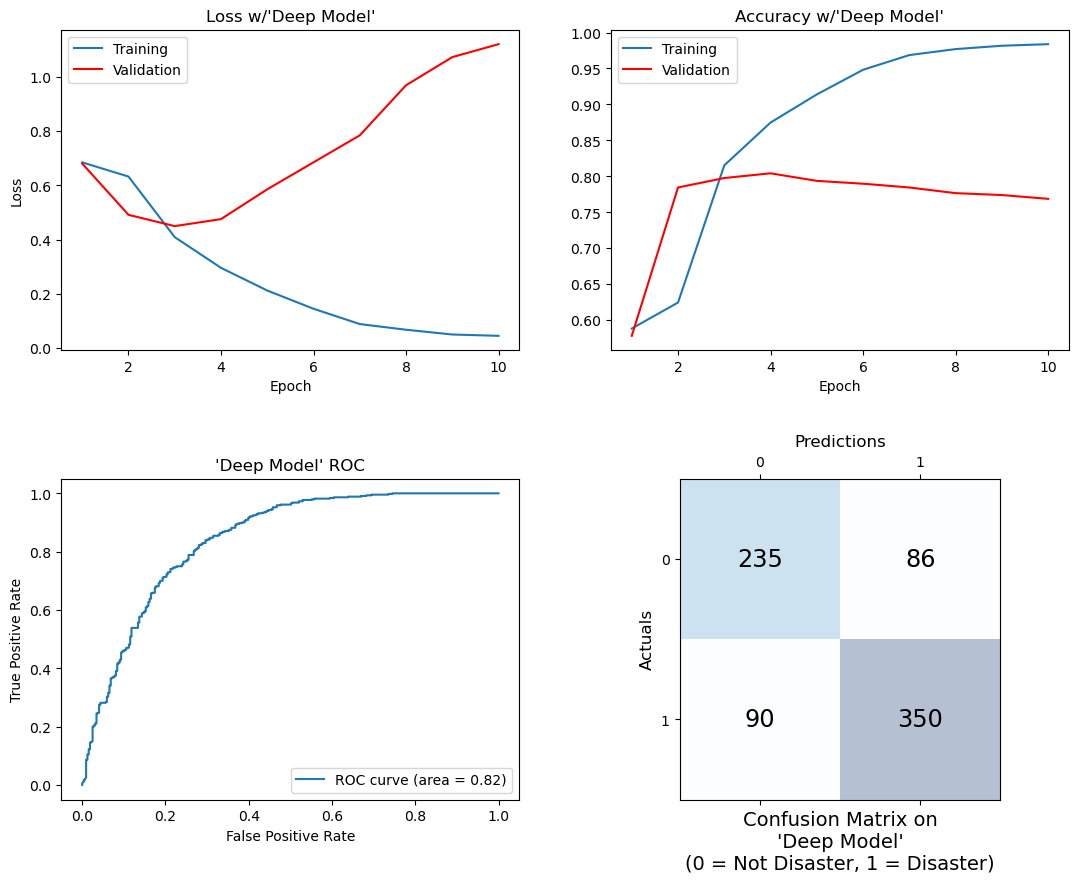

In [63]:
model = Sequential()
model.add(Embedding(uncommonWordCount + numBuckets, modelEmbedSize, input_shape = [None]))
model.add(GRU(16, return_sequences = True))
model.add(GRU(32, return_sequences = True))
model.add(GRU(128, return_sequences = True))
model.add(GRU(128))
model.add(Dense(1, activation = "sigmoid"))

model.compile(optimizer = keras.optimizers.Adam(learning_rate = 0.0001), 
              loss = keras.losses.BinaryCrossentropy(from_logits = False), 
              metrics = METRICS)

hist = model.fit(train_set, validation_data = validation_set, epochs = 10, callbacks = callbacks_list, verbose = False)
preds = model.predict(validation_set)
actuals = []
for _, y in validation_set:
    actuals.extend(list(y))
plotTrainingResults(hist.history, actuals, preds, "'Deep Model'")

As gradually increasing the units in the deeper model did not seem to have much effect, a model with several layers each of 128 units is fitted.  Again, only a slight improvement in F1 is seen, but this comes at the cost of a reduction in the Area Under the ROC (0.82 to 0.80).


Epoch 6: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 8: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 10: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
24/24 [==============================] - 1s 4ms/step
F1 Score:  0.8004561003420751


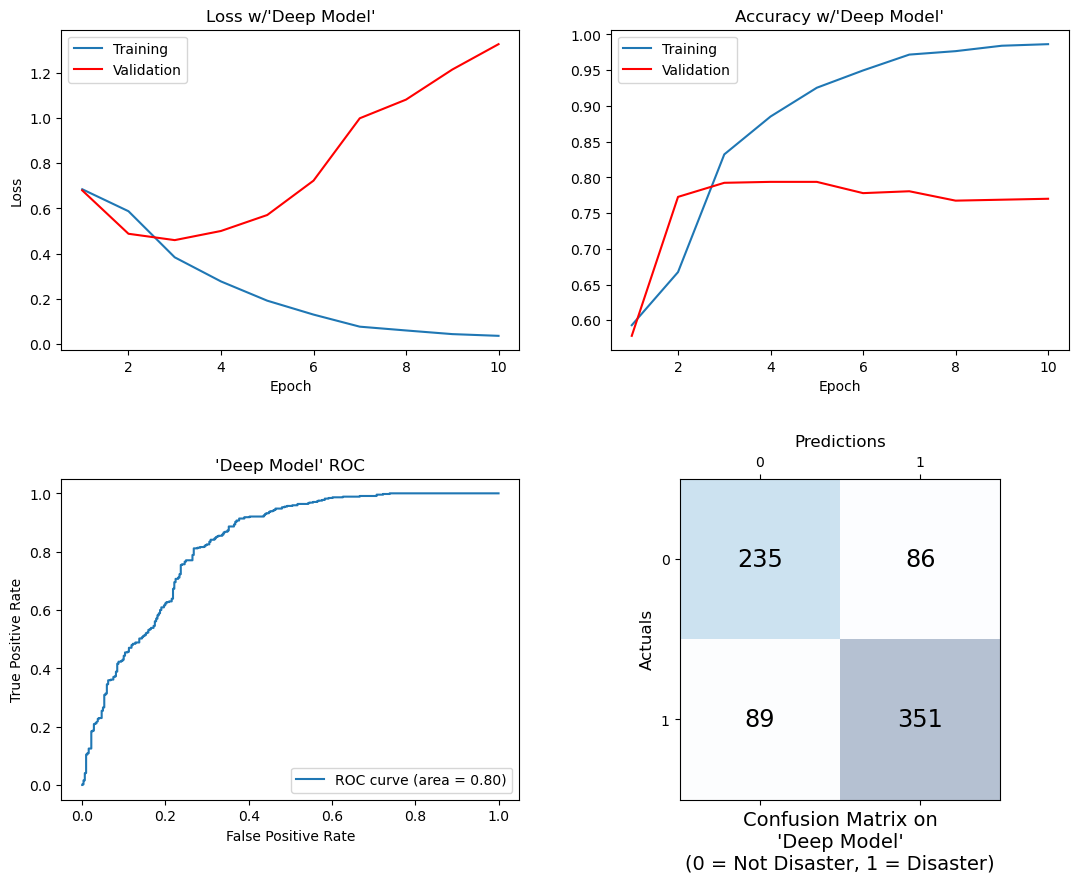

In [65]:
model = Sequential()
model.add(Embedding(uncommonWordCount + numBuckets, modelEmbedSize, input_shape = [None]))
model.add(GRU(128, return_sequences = True))
model.add(GRU(128, return_sequences = True))
model.add(GRU(128, return_sequences = True))
model.add(GRU(128))
model.add(Dense(1, activation = "sigmoid"))

model.compile(optimizer = keras.optimizers.Adam(learning_rate = 0.0001), 
              loss = keras.losses.BinaryCrossentropy(from_logits = False), 
              metrics = METRICS)

hist = model.fit(train_set, validation_data = validation_set, epochs = 10, callbacks = callbacks_list, verbose = False)
preds = model.predict(validation_set)
actuals = []
for _, y in validation_set:
    actuals.extend(list(y))
plotTrainingResults(hist.history, actuals, preds, "'Deep Model'")

As making the model deeper did not seem to have much effect, I decided to try making it _very_ shallow.  Only a single layer and increases in both the F1 score and the Area Under the ROC were seen!


Epoch 3: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 9: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
24/24 [==============================] - 0s 4ms/step
F1 Score:  0.8245810055865921


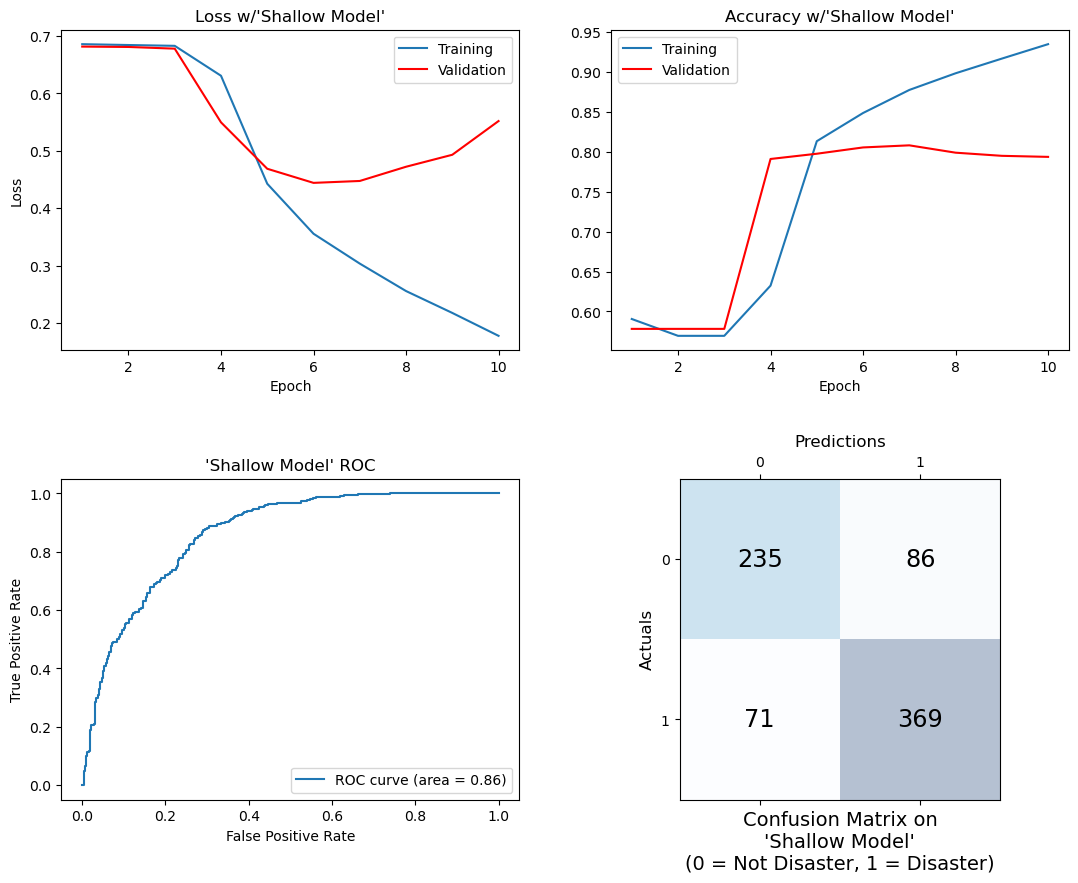

In [68]:
model = Sequential()
model.add(Embedding(uncommonWordCount + numBuckets, modelEmbedSize, input_shape = [None]))
model.add(GRU(128))
model.add(Dense(1, activation = "sigmoid"))

model.compile(optimizer = keras.optimizers.Adam(learning_rate = 0.0001), 
              loss = keras.losses.BinaryCrossentropy(from_logits = False), 
              metrics = METRICS)

hist = model.fit(train_set, validation_data = validation_set, epochs = 10, callbacks = callbacks_list, verbose = False)
preds = model.predict(validation_set)
actuals = []
for _, y in validation_set:
    actuals.extend(list(y))
plotTrainingResults(hist.history, actuals, preds, "'Shallow Model'")

As a single layer seemed to provide the best results, changing the hyperparameter for the number of units in that layer was tried.  Values of 64 and 256 were both used but resulted in reductions both in F1 and Area Under ROC. For that reason, those results are not shown below.  

As a single layer with 128 units seemed to be best, I next tried a model modification to see if the early overfitting in the models previously tried with could be improved with Dropout layers.  I placed a Dropout layer on either side of the single 128 unit GRU and was able to increase both the F1 to .8371 and the Area Under the ROC to 0.87.  

At this point I was happy enough with the model performance to save it and make a submission in the Kaggle competition.

Epoch 1/6
215/215 [==============================] - 4s 12ms/step - loss: 0.6861 - tp: 4227.0000 - fp: 3003.0000 - tn: 268.0000 - fn: 115.0000 - accuracy: 0.5904 - precision: 0.5846 - recall: 0.9735 - auc: 0.5538 - val_loss: 0.6818 - val_tp: 440.0000 - val_fp: 321.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.5782 - val_precision: 0.5782 - val_recall: 1.0000 - val_auc: 0.5057 - lr: 1.0000e-04
Epoch 2/6
215/215 [==============================] - 2s 9ms/step - loss: 0.6841 - tp: 3902.0000 - fp: 2950.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - accuracy: 0.5695 - precision: 0.5695 - recall: 1.0000 - auc: 0.4904 - val_loss: 0.6812 - val_tp: 440.0000 - val_fp: 321.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.5782 - val_precision: 0.5782 - val_recall: 1.0000 - val_auc: 0.5136 - lr: 1.0000e-04
Epoch 3/6
213/215 [============================>.] - ETA: 0s - loss: 0.6834 - tp: 3877.0000 - fp: 2939.0000 - tn: 0.0000e+00 - fn: 0.0000e+00 - accuracy: 0.5688 - prec

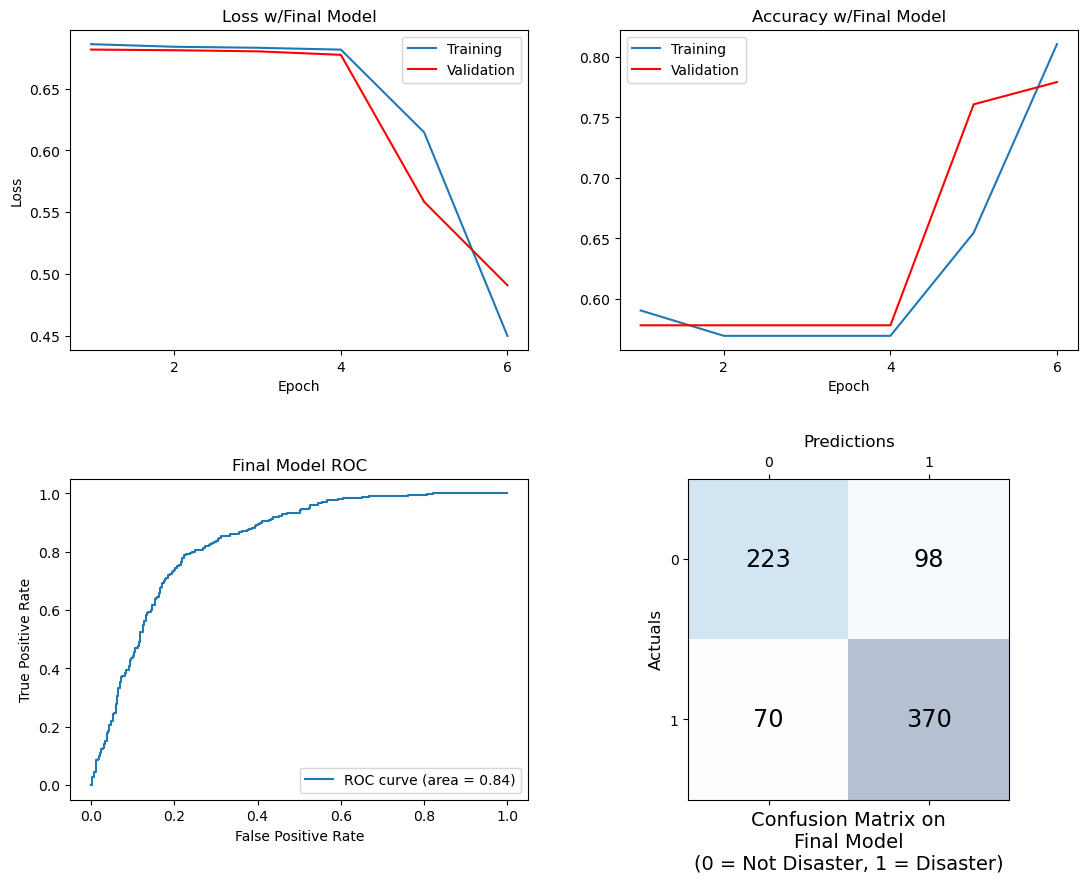

In [117]:
modelEmbedSize = 32
model = Sequential()
model.add(Embedding(uncommonWordCount + numBuckets, modelEmbedSize, input_shape = [None]))
model.add(Dropout(0.2))
model.add(GRU(128))
model.add(Dropout(0.2))
model.add(Dense(1, activation = "sigmoid"))

model.compile(optimizer = keras.optimizers.Adam(learning_rate = 0.0001), 
              loss = keras.losses.BinaryCrossentropy(from_logits = False), 
              metrics = METRICS)

hist = model.fit(train_set, validation_data = validation_set, epochs = 6, callbacks = callbacks_list, verbose = True)
preds = model.predict(validation_set)
actuals = []
for _, y in validation_set:
    actuals.extend(list(y))
plotTrainingResults(hist.history, actuals, preds, "Final Model")
model.save(os.path.join("./Models/", "final_model.h5"))


Epoch 3: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
24/24 [==============================] - 0s 4ms/step
F1 Score:  0.8370535714285713


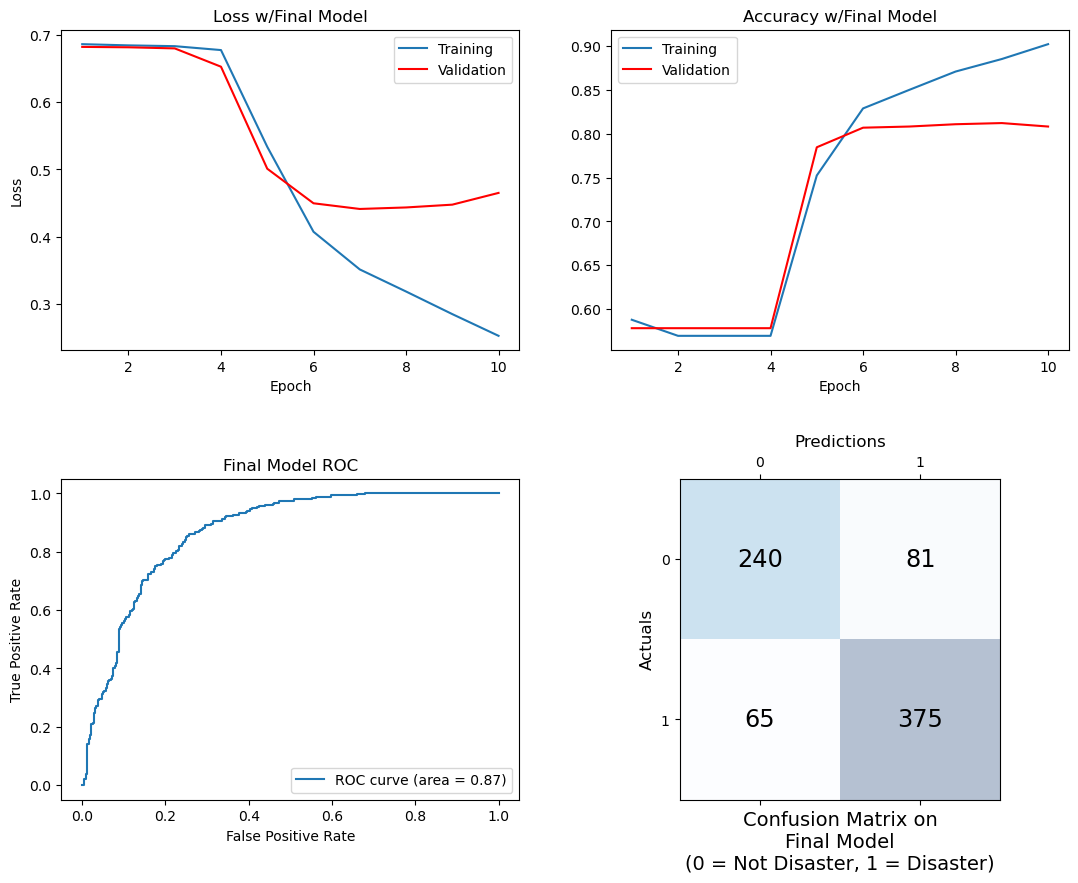

In [115]:
modelEmbedSize = 32
model = Sequential()
model.add(Embedding(uncommonWordCount + numBuckets, modelEmbedSize, input_shape = [None]))
model.add(Dropout(0.2))
model.add(GRU(128))
model.add(Dropout(0.2))
model.add(Dense(1, activation = "sigmoid"))

model.compile(optimizer = keras.optimizers.Adam(learning_rate = 0.0001), 
              loss = keras.losses.BinaryCrossentropy(from_logits = False), 
              metrics = METRICS)

hist = model.fit(train_set, validation_data = validation_set, epochs = 10, callbacks = callbacks_list, verbose = False)
preds = model.predict(validation_set)
actuals = []
for _, y in validation_set:
    actuals.extend(list(y))
plotTrainingResults(hist.history, actuals, preds, "Final Model")
model.save(os.path.join("./Models/", "final_model.h5"))

### Kaggle Submission
We'll load the model first and verify it is the one chosen for use when submitting to Kaggle.

In [94]:
finalModel = tf.keras.models.load_model(os.path.join("./Models/", "final_model.h5"))
finalModel.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, None, 32)          884352    
                                                                 
 dropout_8 (Dropout)         (None, None, 32)          0         
                                                                 
 gru_22 (GRU)                (None, 128)               62208     
                                                                 
 dropout_9 (Dropout)         (None, 128)               0         
                                                                 
 dense_11 (Dense)            (None, 1)                 129       
                                                                 
Total params: 946,689
Trainable params: 946,689
Non-trainable params: 0
_________________________________________________________________


Next we'll use the same text preprocessing function used earlier to remove the words and number from the text in the dataframe.  Once those are removed a file will be created for each Tweet containing the remaining text.

In [100]:
preprocessDataFrame(dfTest)
submitDir = "TestTweets"
os.mkdir(submitDir)
for row in dfTest.itertuples():
    fileName = str(row.id) + ".txt"
    dest = os.path.join(submitDir, fileName)
    with open(dest, 'w', encoding='utf-8') as f:
        f.write(row.text)

Lastly, the submission file will be created by reading the files made in the previous cell into a TensorFlow dataset, using the loaded model to make predictions on that dataset, and then saving those predictions into the necessary file format.

In [104]:
def createSubmissionFile(submissionModel):
    tfdsTest = keras.utils.text_dataset_from_directory(
        submitDir,
        labels = None,
        label_mode = None,
        batch_size = 32,
        max_length = None,
        shuffle = False,
        seed = None,
        validation_split = None,
        subset = None
    )
    
    test_set = tfdsTest.map(preprocessDataSet)
    test_set = test_set.map(encode_words).prefetch(1)
    predictions = submissionModel.predict(test_set)
    dictPred = dict((key, value) for (key, value) in zip(dfTest.id, np.where(predictions[:, 0] < .5, 0, 1)))

    sampleList = list(dfTest.id)
    predictions = [dictPred[id] for id in sampleList]

    dfSubmit = pd.DataFrame({'id':sampleList, 'target':predictions})
    dfSubmit.to_csv('submission.csv', header = True, index = False)
    print("Submission file created!")
    
createSubmissionFile(finalModel)

Found 3263 files belonging to 1 classes.
102/102 [==============================] - 0s 4ms/step
Submission file created!


### Results and Analysis
The final results after model and hyperparameter tuning was a simple model with a single GRU layer sandwiched between two dropout layers. Other models were tried, but this one delivered the best peformance. This single GRU layer tested best with 128 units and the Dropouts both before and after it would drop 20% of samples.  The final model's overall performance on the validation set was:  

|  | Result |
|---|---|
| F1 Score | 0.8376 |
| Accuracy | 0.7792 |
| Precision | 0.7906 |
| Recall | 0.8409 |

### Conclusion and Summary
